In [3]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597640517&Signature=QRdQpSVbTEc2jGyNRotvi7hYO%2BEuWfNLBjmfVggVHIOPykxBu8QENQovyEOEeUCF7C7Nuu2FjpI2jKhLYCuh18NSR1iAC4iGcTWKYG9oBkqA3G0cnjm2vQWnI820mboarvJoyU8rU5%2BTwm4qTdLq9g3a77J3yH%2FwOstZ53cjhnzPTM2O8EjyLzFPZTOqzqieEIlWZB9GKBbFXIjsn6CAFpod437PNHiPRyoLbVOi3kJ8BruAI6gDu0pXf8jCaCSQCJGml0oYPGqVss15NkrwlJcGUHvyVhfKt7S7V%2Fcp%2Br0MZ7p1puJW2F7IYO%2BuQi%2BMJvHxOclbnKRJmaszqiM7gw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'

--2020-08-14 23:24:07--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597640517&Signature=QRdQpSVbTEc2jGyNRotvi7hYO%2BEuWfNLBjmfVggVHIOPykxBu8QENQovyEOEeUCF7C7Nuu2FjpI2jKhLYCuh18NSR1iAC4iGcTWKYG9oBkqA3G0cnjm2vQWnI820mboarvJoyU8rU5%2BTwm4qTdLq9g3a77J3yH%2FwOstZ53cjhnzPTM2O8EjyLzFPZTOqzqieEIlWZB9GKBbFXIjsn6CAFpod437PNHiPRyoLbVOi3kJ8BruAI6gDu0pXf8jCaCSQCJGml0oYPGqVss15NkrwlJcGUHvyVhfKt7S7V%2Fcp%2Br0MZ7p1puJW2F7IYO%2BuQi%2BMJvHxOclbnKRJmaszqiM7gw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456337398 (435M) [application/zip]
Saving to: ‘train.csv.zip’

train.csv.zip       100

In [4]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [31]:
# Improting required libraries.
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
import dask.dataframe as dd
import dask
import gc
warnings.filterwarnings(action='ignore')
sns.set_style('whitegrid')

In [32]:
# This is to be used for memory optimization because the data is very large.
# For more information about iinfo refer- https://numpy.org/doc/stable/reference/generated/numpy.iinfo.html
# np.iinfo gives machine gives machine limits for integer types, so based on max and minimum value  of that feature we can \
# convert the feature values into best suitable optimum datatype to reduce memory usage.
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# In featureModify I encoded the output event of a pilot's state\
# while going through certain experiment.

def featureModify(isTrain, numRows):

    if isTrain:
        df = dd.read_csv('train.csv',nrows=numRows) 
        df = df.compute()
        df = reduce_mem_usage(df)
        df['event'] = df['event'].map({
            'A':0,
            'B':1,
            'C':2,
            'D':3
        })
    else:
        df = dd.read_csv('test.csv',nrows=numRows)
        df = df.compute()
        df = reduce_mem_usage(df)
    
    return df 


In [35]:
# Here we can see the 1.076 GB memory usage was reduced to 278.52 MB so its good for better usage.
train = featureModify(True, None)
y = train['event']
train = train.drop('event',axis=1)
print(train.shape)
print(train.columns)

Memory usage of dataframe is 1076.93 MB
Memory usage after optimization is: 278.52 MB
Decreased by 74.1%
(4867421, 27)
Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')


In [ ]:
# Test data's memory usage was reduced from 3.974 GB to 1.079 GB
test = featureModify(False,None)
print(test.shape)
print(test.columns)

Memory usage of dataframe is 3974.83 MB
Memory usage after optimization is: 1079.37 MB
Decreased by 72.8%
(17965143, 28)
Index(['id', 'crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7',
       'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1',
       'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4',
       'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')


Training on the model with best results: LightGBM

In [ ]:
def pipeline(train,test):
 


  print('Splitting the data into train and cross _validation')
  X_train, X_cv, y_train, y_cv = train_test_split(train, y, test_size=0.25, shuffle=False)
  train = lgb.Dataset(X_train, label = y_train, categorical_feature = [1])
  print('Done')



  print('Making the train and cv data from LightGBM model')
  del y_train
  # gc is garbage collector it returns how many objects it has collected and deallocated.
  gc.collect()
  cv = lgb.Dataset(X_cv, label = y_cv, categorical_feature = [1])
  del y_cv
  gc.collect()
  print('Done')



  # Declaring the hyperparameter values. 
  params = {
          "objective" : "multiclass", # used for multiclass softmax classifier
          "metric" : "multi_error",   # Error rate for multiclass classification 
          "boosting" :'gbdt',         # Using Gardient Boosted Decision Trees
          'num_class':4,              # Number of desired output classes is 4 
          "num_leaves" : 30,          # Number of leaves in Tree based algorithms
          "learning_rate" : 0.01,     
          "bagging_fraction" : 0.9,   # This is randomly select 90% of data without resampling\
                                      # it will decrease impact of high variance on data
          "bagging_seed" : 0,         # Random seeds for bagging
          "num_threads" : 4,
          "colsample_bytree" : 0.5,   # Subsampling fraction for feature
          'min_data_in_leaf':100,     # Threshold on Data in a leaf
          'min_split_gain':0.00019    # Minmimum gain threshold for splitting the node
            }




  # Training Stage:
  print('Training Started:')
  model = lgb.train(  params, 
                      train_set = train,
                      num_boost_round=2000,
                      early_stopping_rounds=200,
                      verbose_eval=100, 
                      valid_sets=[train,cv]
                    )
  print('Training Done!')



  # Exporting the trained model.
  import joblib
  joblib.dump(model,'final_model.pkl')



  print('Predicting the output probabilities for each event for test data:')
  # Saving the ids for further merging of features in csv.
  df_sub = pd.DataFrame()
  df_sub['id'] = test['id']
  test = test.drop('id',axis=1)



  # Predicting the probability values for each event.
  y_pred = model.predict(test,num_iteration=model.best_iteration)
  df_sub = pd.DataFrame(np.concatenate((np.arange(len(test))[:, np.newaxis], y_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
  print('Predictions Done')
  


  # Creating the submission csv file.
  df_sub['id'] = df_sub['id'].astype(int)
  print(df_sub)
  df_sub.to_csv("predictions.csv", index=False)
  
  return y_pred


predictions = pipeline(train,test)


Splitting the data into train and cross _validation
Done
Making the train and cv data from LightGBM model
Done
Training Started:
Training until validation scores don't improve for 200 rounds.
[100]	training's multi_error: 0.0732298	valid_1's multi_error: 0.150007
[200]	training's multi_error: 0.0513315	valid_1's multi_error: 0.0836788
[300]	training's multi_error: 0.0446361	valid_1's multi_error: 0.0819834
[400]	training's multi_error: 0.0376761	valid_1's multi_error: 0.0810803
[500]	training's multi_error: 0.0339035	valid_1's multi_error: 0.0818256
Early stopping, best iteration is:
[392]	training's multi_error: 0.0380341	valid_1's multi_error: 0.08098
Training Done!
Predicting the output probabilities for each event for test data:
Predictions Done
                id         A         B         C         D
0                0  0.973573  0.002153  0.020307  0.003967
1                1  0.969859  0.002878  0.023126  0.004137
2                2  0.973605  0.002191  0.020116  0.004088
3   

This is the kaggle score which I got.I got the public score of 0.31120 and orivate score of 0.55509

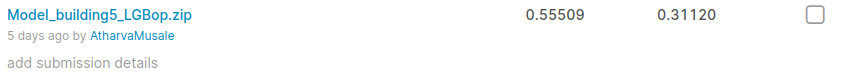

# **Predictions-**

In [4]:
import joblib
model = joblib.load('/content/drive/My Drive/ML case study/models/final_model_cs.pkl')

In [22]:
def function1(X):
  pred = model.predict(X,num_iteration=model.best_iteration)
  return pred

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix
lb = LabelEncoder()
def function2(train,y):
  print('Testing the model for Set of Datapoints:')
  print('#'*40)
  X_train,X_cv,y_train,y_cv = train_test_split(train,y,test_size=0.2,random_state=30)
  y_pred = function1(X_cv)
  y_pred = np.argmax(y_pred, axis=1)
  print('Accuracy score of a model is:',accuracy_score(y_cv,y_pred))
  print('Confusion Matrix of a predictions is:\n',confusion_matrix(y_cv,y_pred))
  print('*'*100)

  print('Testing the model for single input:')
  print('#'*35)
  train['experiment'] = lb.fit_transform(train['experiment'])
  index = np.random.randint(0,30000)
  data = train.iloc[index,:]
  print('Data to be used for prediction is:\n',data)
  print('#'*35)
  y_pred = function1(np.array(data).reshape(1,-1))
  print('Predicted output event is:',np.argmax(y_pred, axis=1))
  ytrue =(y.iloc[index])
  print('Actual output event is:',ytrue)

  print('*'*100)


function2(train,y)

Testing the model for Set of Datapoints:
########################################
Accuracy score of a model is: 0.9512565678978104
Confusion Matrix of a predictions is:
 [[567721    181    375   1015]
 [  9692  16371      0      0]
 [    72      0 330813      0]
 [ 36116      0      0  11129]]
****************************************************************************************************
Testing the model for single input:
###################################
Data to be used for prediction is:
 crew              1.000000
experiment        0.000000
time             10.328125
seat              0.000000
eeg_fp1           4.082031
eeg_f7           -5.148438
eeg_f8           -2.011719
eeg_t4           -0.316162
eeg_t6            2.355469
eeg_t5           -9.617188
eeg_t3            6.359375
eeg_fp2          11.187500
eeg_o1           -1.160156
eeg_p3           -9.742188
eeg_pz           -7.375000
eeg_f3           -8.859375
eeg_fz           -3.935547
eeg_f4           -2.685547
eeg_c4    